# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений разреженных матриц.

In [2]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [2]:
import zipfile

user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [3]:
from scipy.sparse import csr_matrix

A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [4]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx, :], A[train_idx, :]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше). 
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Для начала выведите необходимые формулы аналитически, а затем реализуйте их в коде. Ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо.  Везде считайте $r < m, n$.

![1A](data/1A.jpg)

На фото и в коде порядок умножения под следом отличается тк у меня было какой-то бред с выделением памяти когда я писал часть с ALS и наверное я просто на планшете расписал не в самом эффективном порядке умножение но сложность умножения не изменится от этого

In [5]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """
    # U матрица показывающая какие фильмы смотрел пользователь (плотная)
    # VT матрица показывающая какие пользователи смотрели фильм (плотная)
    # A матрица показывающая оценки пользователей фильмам (разряженная)
    norm = A_norm ** 2 - 2 * np.trace(VT @ A.T @ U) + np.trace((VT @ VT.T) @ (U.T @ U))

    return np.sqrt(norm)

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** *Расстоянием от подпространства* $L_1 \subset \mathbb{R}^m$ *до подпространства* $L_2 \subset \mathbb{R}^m$ будем называть число $\|(I - P(L_1)) P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Функция несимметричная, так что будьте осторожны с расстановкой аргументов. Опишите алгоритм вычисления расстояния от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^\top U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

![2try](data/2try.jpg)

  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [67]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance from Im(U1) to Im(U2)
    """
    R = U2.T - U2.T @ U1 @ U1.T  # вычисление матрицы R
    sigma = np.linalg.svd(R, full_matrices=False, compute_uv=False)  # сингулярные числа матрицы R без вычисления U, V
    return sigma[0]

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|(I - P(U_{k-1}))P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию. 

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [94]:
from scipy.sparse.linalg import norm as sparse_norm


def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration

        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances from Im(U_{k-1}) and Im(U_k)
    """
    fs = []
    deltas = []
    dists = []
    m, n = A.shape
    U = np.random.rand(m, rank)
    V = np.random.rand(n, rank)
    U, _ = np.linalg.qr(U)  # ортогонализация столбцов матрицы U
    f_start = als_functional(A, sparse_norm(A), U, V.T)  # вычисление функционала для начального приближения U, V
    iter = 0

    # Идея минимизировать функционал чередуя по какой переменной
    # минимизировать функционал по U, а затем по V
    while True:
        # Запоминаем U
        U_old = U.copy()

        # Оптимизация по U
        U = A @ V  # умножение разряженной матрицы A на плотную матрицу V чтобы лучше приблизить A с использованием текущего V. Это для того чтобы лучше подстроить U под A. Грубо говоря обновляю U чтобы лучше минизировать разность функционала делая аппроксимацию A более точной
        U, _ = np.linalg.qr(U)  # ортогонализация столбцов матрицы U

        # Оптимизация по V.1
        V = A.T @ U  # делаю тоже самое что и для U, но теперь для V описано выше

        # вычисление функционала для текущего приближения U, V
        f = als_functional(A, sparse_norm(A), U, V.T)
        fs.append(f)

        # Оптимизация по V.2
        V, _ = np.linalg.qr(V)  # ортогонализация столбцов матрицы V

        # вычисление изменения функционала
        delta = abs(f_start - f)
        deltas.append(delta)

        # обновляем стартовый (предыдущий по фатку но лень переименовать) функционал
        f_start = f

        # вычисление расстояния между пространствами
        dist = dist_between_subspaces(U_old, U)
        dists.append(dist)

        if debug:
            print(f"Iteration {iter}, delta = {delta}, dist = {dists}, f_val = {f}")
        if delta <= tolerance:
            break
        iter += 1
    return U, V.T, fs, deltas, dists

Запустим метод на матрице `A_train` и посмотрим на убывание функционала от номера итерации.

Iteration 0, delta = 384.54713398430886, dist = [0.9999998643823527], f_val = 1777.6244655173423
Iteration 1, delta = 115.1346968936457, dist = [0.9999998643823527, 0.8707073917024111], f_val = 1662.4897686236966
Iteration 2, delta = 15.300392642976021, dist = [0.9999998643823527, 0.8707073917024111, 0.553760579145488], f_val = 1647.1893759807206
Iteration 3, delta = 4.807427539309401, dist = [0.9999998643823527, 0.8707073917024111, 0.553760579145488, 0.35756600385627607], f_val = 1642.3819484414112
Iteration 4, delta = 2.1754996525298793, dist = [0.9999998643823527, 0.8707073917024111, 0.553760579145488, 0.35756600385627607, 0.2878065699227698], f_val = 1640.2064487888813
Iteration 5, delta = 1.1810782062855196, dist = [0.9999998643823527, 0.8707073917024111, 0.553760579145488, 0.35756600385627607, 0.2878065699227698, 0.23638956930073438], f_val = 1639.0253705825958
Iteration 6, delta = 0.6910822352815558, dist = [0.9999998643823527, 0.8707073917024111, 0.553760579145488, 0.3575660038

[]

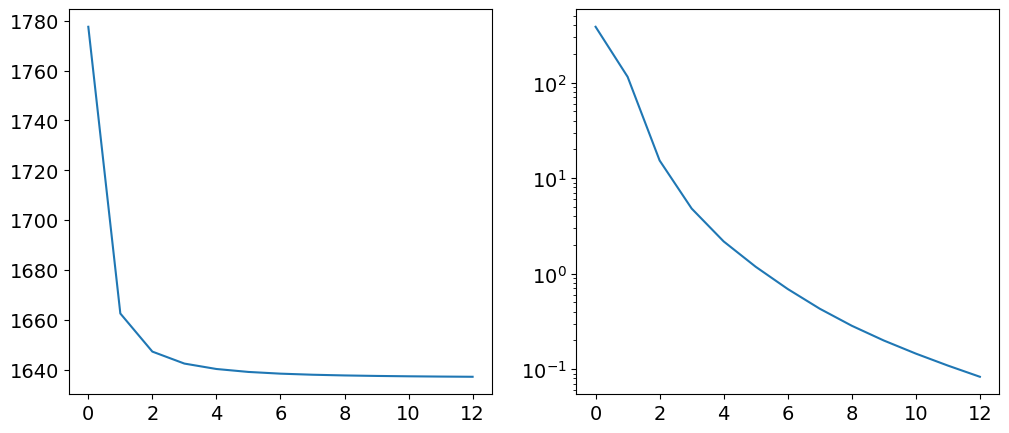

In [95]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy()

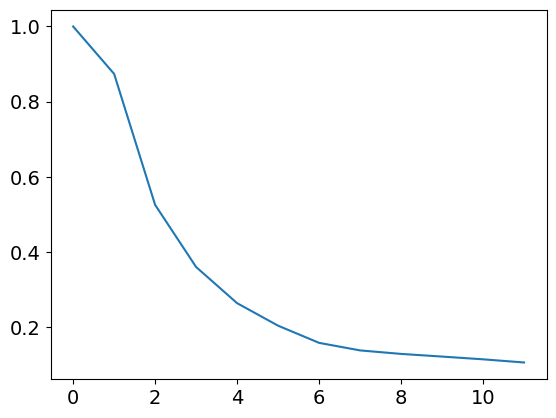

In [77]:
# опционально

plt.plot(dists)

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

ну как я понял третий результат это результат просто als

In [71]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)
# Рандомизированное SVD sklearn
U_rand, Sigma_rand, VT_rand = randomized_svd(A_train, n_components=30)

# SVD scipy
U_svd, Sigma_svd, VT_svd = svds(A_train, k=30)

# ALS
U_als, VT_als, _, _, _ = ALS(A_train, 30)

# Функциональные значения
functional_rand = als_functional(A_train, A_norm, U_rand, VT_rand)
functional_svd = als_functional(A_train, A_norm, U_svd, VT_svd)
functional_als = als_functional(A_train, A_norm, U_als, VT_als)

print("Functional value for randomized SVD: ", functional_rand)
print("Functional value for sparse SVD: ", functional_svd)
print("Functional value for ALS: ", functional_als)

Functional value for randomized SVD:  1997.9740316669513
Functional value for sparse SVD:  1997.9730361857933
Functional value for ALS:  2000.4126236584966


### d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `pred_am` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`pred_am` рекомендаций, то есть `pred_am` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `score_mat` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же. **Подсказка:** используйте функцию `np.argsort`.

In [93]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array
            
        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    recs = []
    proj = score_mat @ (V @ V.T)  # проекция на пространство L
    for movies in proj:
        recs.append(np.argsort(movies)[::-1][:pred_am])  # сортировка по убыванию и выбор первых pred_am элементов
    return np.array(recs)

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [34]:
from scipy.sparse import find


def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user, :])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:, -1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `pred_ams`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `pred_ams == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [80]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users 
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    hit_rates = []  # список хитрейтов
    max_pred_am = max(pred_ams)  # максимальное количество рекомендаций
    hit_idx = evaluate_model(A_test, max_pred_am, V)  # вычисление хитрейтов для всех пользователей из A_test
    for pred_am in pred_ams:
        hits = sum([idx < pred_am for idx in hit_idx])  # количество хитов
        hit_rates.append(hits / len(hit_idx))  # вычисление хитрейта
    return hit_rates

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

In [89]:
A_test_new = A_test[:1000, :]
VT_svd_new = svds(A_train, k=30)[2][
             ::-1]  # взял первые 30 столбцов из VT и перевернул их чтобы макс была с самого начала
hit_rates = get_hit_rates(A_test_new, [10], VT_svd_new.T)
print("Hit rate for top-10 recommendations: ", hit_rates[0] * 100, "%")

Hit rate for top-10 recommendations:  11.518858307849133 %


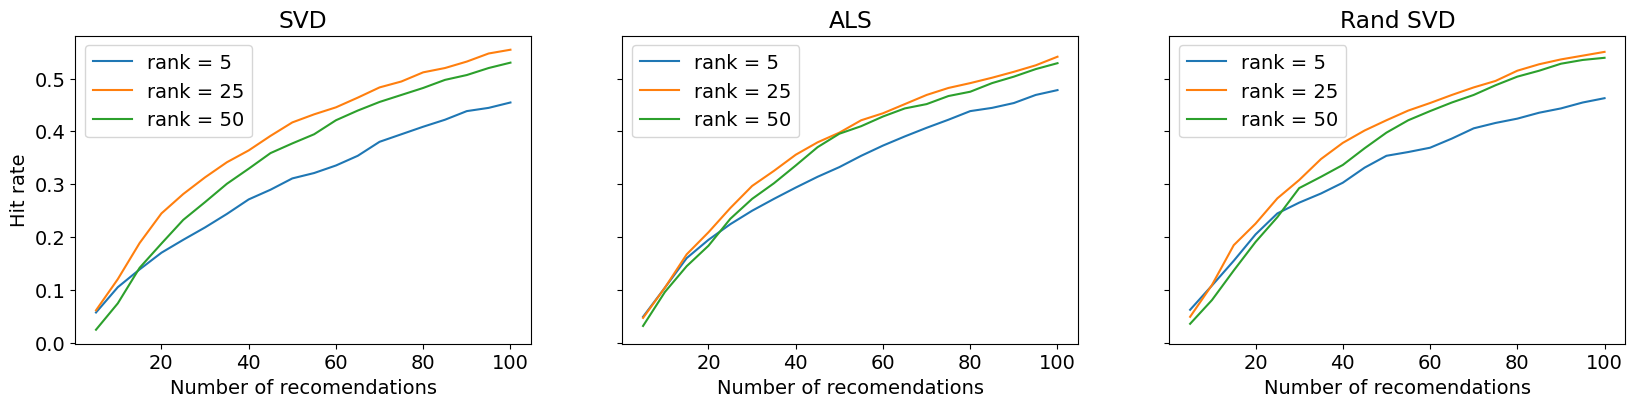

In [96]:
from scipy.sparse.linalg import svds

# работало 15 мин не советую пробовать
pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
_, _, VT_svd = svds(A_train, k=rank)
_, VT_als, _, _, _ = ALS(A_train, rank)
_, _, VT_rand = randomized_svd(A_train, rank)
for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
    ax.set_xlabel("Number of recomendations")
    hit_rates = get_hit_rates(A_test[:1000, :], pred_ams, VT.T)
    line, = ax.plot(pred_ams, hit_rates)
    line.set_label('rank = {}'.format(rank))
    ax.legend()

## Выводы
1. ALS и SVD дают примерно одинаковые результаты, но ALS работает быстрее
2. Рандомизированный SVD работает чуть хуже, чем обычный SVD, но зато быстрее
3. Хитрейт растёт с увеличением количества рекомендаций, но не линейно. Это означает, что модель не уверена в каждой рекомендации, и чем больше рекомендаций, тем больше вероятность, что среди них окажется хорошая
4. В целом алгоритм показал результат - хитрейт около 12% для top-10 рекомендаций что значит что в 12% случаев пользователь найдет фильм который ему понравится

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Думаю что самый оптимальный ранг это 25, так как он дает хороший результат и при этом работает быстрее чем альтернатива ему.